Imports

In [41]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# %load_ext autoreload
#%autoreload 2

# import re


In [90]:
# np.random.random(1) # first result choosing male

In [91]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

In [92]:
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


1. Preprocessing / Data Cleaning


In [93]:
if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)

In [94]:
clean_df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,1,61.0,0,0,1,Self-employed,0,202.21,NaN,never smoked,1
2,31112,0,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1


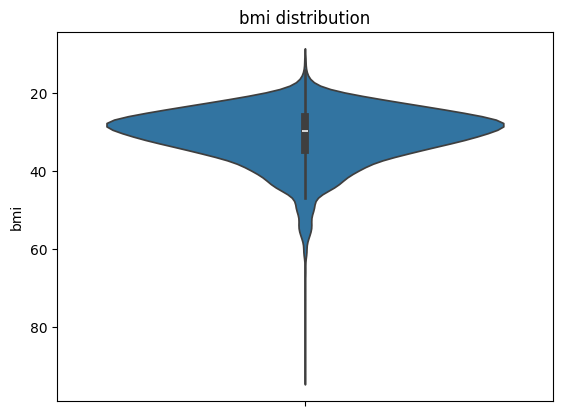

In [122]:
sns.violinplot(y=clean_df['bmi'])

plt.title('bmi distribution')
plt.ylabel('bmi')
plt.gca().invert_yaxis()

plt.show()

In [105]:
max(clean_df.bmi)

92.0

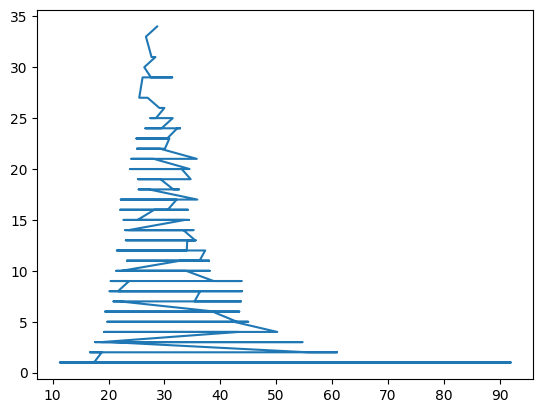

In [123]:
plt.plot(clean_df.bmi.value_counts())

In [96]:
plt.figure(figsize = (20,20))
sns.heatmap(round(clean_df.corr(),2), cmap = "hsv", annot = True, annot_kws = {"size":14})
# hsv terrain jet rainbow tab10 Pastel1 Set3 RdBu viridis inferno plasma cividis magma

ValueError: could not convert string to float: 'Private'

<Figure size 2000x2000 with 0 Axes>

2. Normalisation de la donnée

In [95]:
clean_df.stroke.value_counts(normalize=True)

stroke
0    0.930226
1    0.069774
Name: proportion, dtype: float64

3. Extraire les informations importantes


A partir de 55 ans, chaque décénie double le risque d'AVC.



D'après :
Rothwell PM, Coull AJ, Silver LE, et al. Population-based study of event-rate, incidence, case fatality, and mortality for all acute vascular events in all arterial territories (Oxford vascular study). Lancet 2005; 366 : 1773–83.

4. La veille 😢😢😢


4.1 La classification supervisée

Décrire le concept lui même puis 3 algos

4.2 1er algorithme de classification supervisée

4.2 2e algorithme de classification supervisée

4.3 3e algorithme de classification supervisée

4.99. La veille est enfin finit ! 🙂🙂🙂